<a href="https://colab.research.google.com/github/pakrentos/eeg_connectivity/blob/master/RedArticle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import scipy as sp
import random
from scipy.integrate import solve_ivp as ivp
from scipy.signal import butter, lfilter
from matplotlib import pyplot as plt
from os.path import join
import time
from tensorflow.keras import layers
from tensorflow.keras import regularizers
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
import keras.metrics as metrics
from sklearn import preprocessing
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score
import math
import os
from sklearn.model_selection import ShuffleSplit
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd

Метрики

In [ ]:
def coeff_determination(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [ ]:
def normalize(arr:np.array):
    return (arr - arr.min())/(arr.max()-arr.min())

Осциллятор Рёсслера

In [ ]:
a = 0.15
p = 0.2
c = 10
fps = 100
start_time = 0
end_time = 50
omega = np.array([0.99, 0.95])
epsylon = np.array([0, 0.15])
idx = []
for i in range(0, fps*(end_time-start_time)):
    idx.append(i)

num_epochs = 50
num_trains = 100

Диффур

In [ ]:
"""
Indeces
X1 = 0
Y1 = 1
Z1 = 2
X2 = 3
Y2 = 4
Z2 = 5
"""
def rossler(t, vec: np.array):
    res = np.zeros(6)
    x = vec[0:4:3]
    y = vec[1:5:3]
    z = vec[2:6:3]
    res[0:4:3] = -omega*y - z + epsylon*(x[::-1] - x)
    res[1:5:3] = omega*x + a*y
    res[2:6:3] = p + z*(x-c)
    return res

Решение диффура

In [ ]:
time=np.linspace(start_time, end_time, num=int(fps*end_time))
z0 = np.zeros(6)
z0[0] = 10
z0[1] = 5
z0[2] = 4
z0[3] = 10
z0[4] = 5
z0[5] = 4
res = ivp(rossler, (start_time,end_time), z0, t_eval=time)
data = res['y']
time = res['t']
data = data.T
data = normalize(data)

In [ ]:
data = normalize(data)

Визуализация

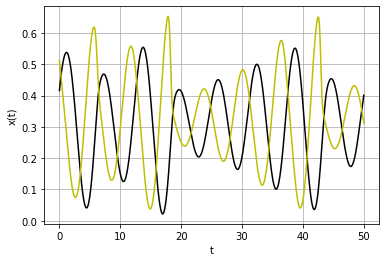

In [ ]:
t = 100
plt.plot(time[0:fps*t], data[0:fps*t, 4], 'k', label='Dependent system 2')
plt.plot(time[0:fps*t], data[0:fps*t, 0], 'y', label='Independent system 1')
plt.xlabel('t')
plt.ylabel('x(t)')
plt.grid()
plt.show()

Модели

Кастомный коллбэк

In [ ]:
class EarlyStopDifference(keras.callbacks.Callback):
    # Custom callback that stops training if the difference between training and validation
    # loss function is more than delta for the past patience training epochs
    
    ### Parameters:
    ### min_delta: Integer, default=0; Minimal affordable difference between loss functions
    ### patience: Integer, default=0; Number of epochs it is tolerable to have difference greater than delta
    ### verbose: Integer, default=0; Prints output if it is 1
    
    def __init__(self, patience=0, min_delta=0, verbose=0):
        # Initializing parameters
        super(EarlyStopDifference, self).__init__()
        self.patience=patience
        self.min_delta=min_delta
        self.verbose=verbose
        self.counter=0
    
    def on_train_begin(self, logs=None):
        # The number of epoch it has waited when loss is no longer minimum.
        self.wait = 0
        # The epoch the training stops at.
        self.stopped_epoch = 0
        # Initialize the best as infinity.
        self.best = np.Inf

    def on_epoch_end(self, epoch, logs=None):
        # Recieving loss function values
        mse = logs['loss']
        val_mse = logs['val_loss']
        # Comparing them to delta
        if self.verbose == 1:
            print("Epoch: ", epoch, "; Value: ", abs(mse - val_mse))
        if (abs(mse - val_mse) <= self.min_delta):
            # Resetting counter
            self.wait = 0
        else:
            # Incrementing counter
            self.wait += 1
            if self.wait >= self.patience:
                # Stopping the model if wait >= patience
                self.stopped_epoch = epoch
                self.model.stop_training = True
                self.model.flag=1
            
    def on_train_end(self, logs=None):
        # Printing the epoch the model has stopped
        if ((self.stopped_epoch > 0) and (self.verbose == 1)):
            print("Epoch %05d: early stopping" % (self.stopped_epoch + 1))   

    

Создание модели

In [ ]:
#Создание модели
def baseline_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(3, activation='linear'))
    model.add(layers.Dense(10, kernel_initializer='random_normal', bias_initializer='zeros', activation='tanh'))
    model.add(layers.Dense(10, kernel_initializer='random_normal', bias_initializer='zeros', activation='tanh'))
    model.add(layers.Dense(3, activation='linear'))
    #Компиляция модели
    model.compile(loss='mse', optimizer=tf.optimizers.Adam(0.01), metrics=[coeff_determination])
    return model

In [ ]:
model_dir = 'D:\\Jupyterlabs\\Assignment\\saved_models\\best_model.h5'

In [ ]:
my_callbacks = [
#     tf.keras.callbacks.EarlyStopping(monitor= , mode='min', patience=10),
    EarlyStopDifference(patience=10, min_delta=0.00001,  verbose=0),
#     tf.keras.callbacks.EarlyStopping(patience=99999, monitor='val_coeff_determination', min_delta=0.001, restore_best_weights=True),
    tf.keras.callbacks.EarlyStopping(patience=15, min_delta=0.0001, restore_best_weights=False),
]

In [ ]:
rsq = []
hist = []
best_r2=-999999999999
best_model = -1

src_init  = data[:, 0:3]
trgt_init = data[:, 3:6]
model = baseline_model()
model.flag = 1
i = 1
while model.flag!=0:
    print('Model: ', i, 'Training start!')
    random.seed(i)
    split_idx = random.sample(idx, int(fps*(end_time-start_time)/2))
    val_src = np.delete(src_init, split_idx, axis=0)
    val_trgt = np.delete(trgt_init, split_idx, axis = 0)
    model = baseline_model()
    model.flag=0
    history = model.fit(src_init[split_idx, 0:3], trgt_init[split_idx, 0:3],
                        epochs=num_epochs, batch_size=64, callbacks=my_callbacks, validation_data=(val_src, val_trgt),
                        verbose=0)
    r2=max(history.history['val_coeff_determination'])
    if (best_r2 < r2) & (len(history.history['loss']) > 15):
        best_r2 = r2
        best_model = i
        model.save(model_dir)
#     rsq.append(r2)
#     hist.append(history) 
    print('Model: ', i, 'Training end, flag = ', model.flag)
    i+=1

Model:  1 Training start!
Model:  1 Training end, flag =  1
Model:  2 Training start!
Model:  2 Training end, flag =  1
Model:  3 Training start!
Model:  3 Training end, flag =  1
Model:  4 Training start!
Model:  4 Training end, flag =  1
Model:  5 Training start!
Model:  5 Training end, flag =  1
Model:  6 Training start!
Model:  6 Training end, flag =  1
Model:  7 Training start!
Model:  7 Training end, flag =  1
Model:  8 Training start!
Model:  8 Training end, flag =  1
Model:  9 Training start!
Model:  9 Training end, flag =  1
Model:  10 Training start!
Model:  10 Training end, flag =  1
Model:  11 Training start!
Model:  11 Training end, flag =  1
Model:  12 Training start!
Model:  12 Training end, flag =  1
Model:  13 Training start!
Model:  13 Training end, flag =  1
Model:  14 Training start!
Model:  14 Training end, flag =  1
Model:  15 Training start!
Model:  15 Training end, flag =  1
Model:  16 Training start!
Model:  16 Training end, flag =  1
Model:  17 Training start!

In [ ]:
rsq = []
hist = []
best_r2=-999999999999
best_model = -1

src_init  = data[:, 0:3]
trgt_init = data[:, 3:6]
for i in range(0, num_trains):
    print('Model: ', i+1, 'Training start:')
    random.seed()
    split_idx = random.sample(idx, int(fps*(end_time-start_time)/2))
    val_src = np.delete(src_init, split_idx, axis=0)
    val_trgt = np.delete(trgt_init, split_idx, axis = 0)
    model = baseline_model()
    history = model.fit(src_init[split_idx, 0:3], trgt_init[split_idx, 0:3],
                        epochs=num_epochs, batch_size=64, callbacks=my_callbacks, validation_data=(val_src, val_trgt),
                        verbose=0)
    r2=max(history.history['val_coeff_determination'])
    if (best_r2 < r2) & (len(history.history['loss']) > 15):
        best_r2 = r2
        best_model = i
        model.save(model_dir)
    rsq.append(r2)
    hist.append(history)

In [ ]:
print(max(rsq), best_model)

ValueError: max() arg is an empty sequence

In [ ]:
src_init  = data[:, 0:3]
trgt_init = data[:, 3:6]
split_idx = random.sample(idx, int(fps*(end_time-start_time)/2))
val_src = np.delete(src_init, split_idx, axis=0)
val_trgt = np.delete(trgt_init, split_idx, axis = 0)

In [ ]:
model = keras.models.load_model(model_dir, custom_objects={'coeff_determination': coeff_determination})

In [ ]:
res = model.predict(val_src, batch_size=32)

In [ ]:
print(res.shape, val_trgt.shape)

(2500, 3) (2500, 3)


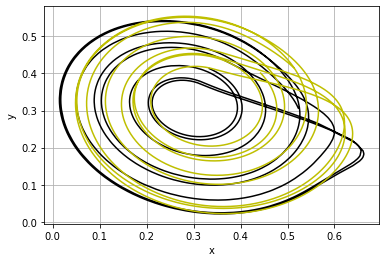

In [ ]:
plt.plot(res[:, 0], res[:, 1], 'k', label='Dependent system 2')
plt.plot(trgt_init[:, 0], trgt_init[:, 1], 'y', label='Independent system 1')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.show()

In [ ]:
plot_history(hist[best_model-1])

IndexError: list index out of range

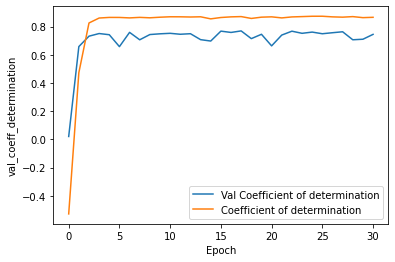

In [ ]:
plot_history2(histor)

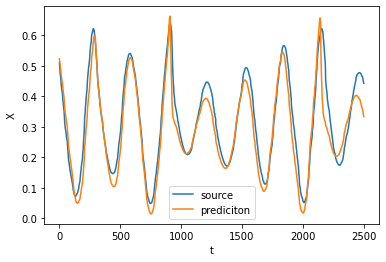

In [ ]:
### Данные, которые мы предсказываем
a = range(0, 2500)
plt.figure()
plt.plot(a, val_trgt[:, 0:1], label='source')
plt.plot(a, res[:, 0:1], label='prediciton')
plt.xlabel('t')
plt.ylabel('X')
plt.legend()
plt.show()

In [ ]:
r2_score(res[:, 0:1], val_trgt[:, 0:1])

0.8611288057261912

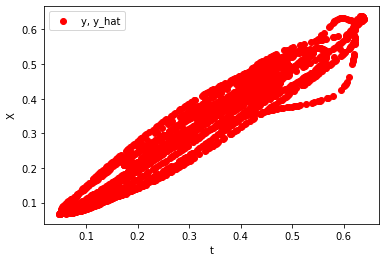

In [ ]:
### Данные, которые мы предсказываем
a=[]
for i in range(0, 12500):
    a.append(i/12500)
plt.figure()
# plt.plot(a, a, label='best_case')
plt.scatter(val_trgt[:, 0:1], res[:, 0:1], label='y, y_hat', color='r')
plt.xlabel('t')
plt.ylabel('X')
plt.legend()
plt.show()

In [ ]:
a = pd.DataFrame(hist[best_model].history)
a.describe()

IndexError: list index out of range

In [ ]:
###ADDED
### Рисует график обучения (loss function) и график метрики (coeff_determination). Своровано и адаптировано отсюда: https://www.tensorflow.org/tutorials/keras/regression?hl=ru
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(hist['epoch'], hist['loss'],
           label = 'Loss function')
    plt.plot(hist['epoch'], hist['val_loss'],
           label = 'val_loss')
    plt.legend()
    plt.show()


In [ ]:
def plot_history2(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('val_coeff_determination')
    plt.plot(hist['epoch'], hist['val_coeff_determination'],
           label='Val Coefficient of determination')
    plt.plot(hist['epoch'], hist['coeff_determination'],
           label='Coefficient of determination')
    plt.legend()
    plt.show()


In [ ]:
hist = pd.DataFrame(histories.history)
hist.describe()

NameError: name 'histories' is not defined